In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# **Initializing objects:**

In [86]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  1
my_dt = 1/24/60/10 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')

Sat created


In [87]:
my_scanner = Scanner(zeta_limit=np.radians(40) ,double_telescope=True) 
print('Scanner created')

num_sources=5

Scanner created


In [88]:
alphas, deltas = ([], [])
for t in np.linspace(t_init+my_dt, t_end, num=num_sources, endpoint=False):
    attitude = gaia.func_attitude(t)
    alpha, delta = generate_observation_wrt_attitude(attitude)
    alphas.append(alpha)
    deltas.append(delta)

In [89]:
for a,d in zip(alphas, deltas):
    print(a,d)

5.7124522469908205 6.05218027498393
2.3589106372896618 5.921192653521425
5.1165215713322 0.9163035501431107
0.72777876568499 5.089758594906014
2.9173871044822404 0.7859049143300056


In [90]:
for a,d in zip(alphas, deltas):
    print(a,d)

5.7124522469908205 6.05218027498393
2.3589106372896618 5.921192653521425
5.1165215713322 0.9163035501431107
0.72777876568499 5.089758594906014
2.9173871044822404 0.7859049143300056


In [91]:
# Generate telescopes positions
alphas_P, deltas_P, alphas_F, deltas_F = ([], [], [], [])
for t in np.linspace(t_init, t_end, num=100):
    a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
    alphas_P.append(a_P-np.pi)
    deltas_P.append(d_P)
    alphas_F.append(a_F-np.pi)
    deltas_F.append(d_F)

(None, Text(0.5, 0, 'alpha'), Text(0, 0.5, 'delta'))

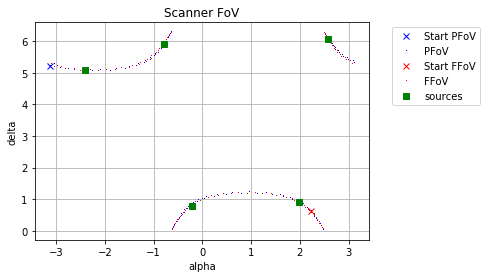

In [92]:
fig = plt.figure()
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P, deltas_P, 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F, deltas_F, 'r,', label='FFoV')

plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')

plt.title("Scanner FoV")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')

(None, Text(0.5, 0, 'alpha'), Text(0, 0.5, 'delta'))

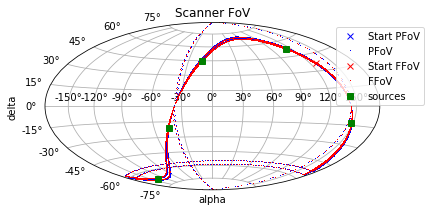

In [93]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P, deltas_P, 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F, deltas_F, 'r,', label='FFoV')

plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')

plt.title("Scanner FoV")
plt.legend(loc=9, bbox_to_anchor=(1, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')

In [94]:
# create soures from that: 
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), alphas[n], deltas[n], 100, 100, 100, 5))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Sources created


In [95]:
# generate_observation_wrt_attitude(attitude)

# **Scan**

In [96]:
for s in sources:
    print(s.alpha, s.delta)

0.09970110007293816 0.10563047272272538
0.04117075738102233 0.10334430744884868
0.0893001476690608 0.01599251389771024
0.0127021356873034 0.08883304561279023
0.05091801052843892 0.013716628362662565


In [97]:
obs_times = []
calc_sources = []
for s in sources:
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    obs_times += my_scanner.obs_times
    # print('Error: ', my_scanner.scanner_error())
    calc_sources.append(Calc_source(obs_times=my_scanner.obs_times, source=s))
    print('------------------------------------------------------')


Starting scan with time from 0 to 1 days
Total measured time: 0.012317419052124023
zetas: []
etas: []
times: []
How many observation time?  0
------------------------------------------------------
Starting scan with time from 0 to 1 days
Total measured time: 0.018910646438598633
zetas: [0.685984800174448, 0.6811914355347869, 0.6807197393042301, 0.6758418832637301]
etas: [-2.220446049250313e-16, 3.3306690738754696e-16, -3.3306690738754696e-16, 1.1102230246251565e-16]
times: [0.06603301369227714, 0.4199722910866117, 0.5682690399939972, 0.9221875010101364]
How many observation time?  4
------------------------------------------------------
Starting scan with time from 0 to 1 days
Total measured time: 0.01858663558959961
zetas: [0.6970266714883768, 0.6891453111435051, 0.6873819890111066, 0.679427927201965]
etas: [1.1102230246251565e-16, -3.3306690738754696e-16, -5.551115123125783e-16, 2.220446049250313e-16]
times: [0.07629440281042682, 0.430225310481383, 0.5785090768468661, 0.9324025215638

In [98]:
0.07489383113737533 - 0.07489383113737533

0.0

In [99]:
list(np.sort(obs_times))

[0.06603301369227714,
 0.0664266181674323,
 0.07489172062961907,
 0.07629440281042682,
 0.4199722910866117,
 0.42024758349178737,
 0.42869947827590255,
 0.430225310481383,
 0.5682690399939972,
 0.5685199377061398,
 0.5769607569559676,
 0.5785090768468661,
 0.9221875010101364,
 0.9223211139636504,
 0.9307360589378906,
 0.9324025215638754]

# **2- Combine with solver:**

In [100]:
def noise_calc_sources(s):
    noise = 0.02 / 10
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [101]:
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=True)

In [102]:
Solver.error_function()

0.0

In [103]:
# Solver.reset_iterations()
Solver.iterate(10)

***** Iteration: 1 *****
Error after iteration: 0.0
***** Iteration: 2 *****
Error after iteration: 0.0
***** Iteration: 3 *****
Error after iteration: 0.0
***** Iteration: 4 *****
Error after iteration: 0.0
***** Iteration: 5 *****
Error after iteration: 0.0
***** Iteration: 6 *****
Error after iteration: 0.0
***** Iteration: 7 *****
Error after iteration: 0.0
***** Iteration: 8 *****
Error after iteration: 0.0
***** Iteration: 9 *****
Error after iteration: 0.0
***** Iteration: 10 *****
Error after iteration: 0.0


In [104]:
gaia.wz

25.132741228718345

# *Update Attitude*

In [105]:
np.array([1,3,2])-1

array([0, 2, 1])

In [106]:
np.radians(0.6)

0.010471975511965976

In [107]:
t_list = get_interesting_days(t_init, t_end, sat=gaia, source=sources[0])
t_list

[]

In [108]:
spline_degree = 3
Solver = Agis(gaia, calc_sources, real_sources=sources, updating='attitude',
              attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=1e-2)

In [109]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
# Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-8
print('c_noise shape: ', c_noise.shape)
Solver.att_coeffs[:] = Solver.att_coeffs[:] + c_noise[:]
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  3.790480129960047e-06
c_noise shape:  (4, 14402)
Error after Noise:  3.790518061691069e-06


**Plot matrices:**

In [110]:
print(Solver.att_knots.shape)
print(Solver.att_coeffs.shape[1])

(14405,)
14402


In [112]:
N_aa = Solver.compute_attitude_LHS()

14402


MemoryError: 

In [53]:
N_aa_w = N_aa[0::4, 0::4]
N_aa_x = N_aa[1::4, 1::4]
N_aa_y = N_aa[2::4, 2::4]
N_aa_z = N_aa[3::4, 3::4]
N_aa_list = [N_aa_w, N_aa_x, N_aa_y, N_aa_z]
print('N_aa_w.shape', N_aa_w.shape)
print('N_aa_z.shape', N_aa_z.shape)

NameError: name 'N_aa' is not defined

NameError: name 'N_aa_list' is not defined

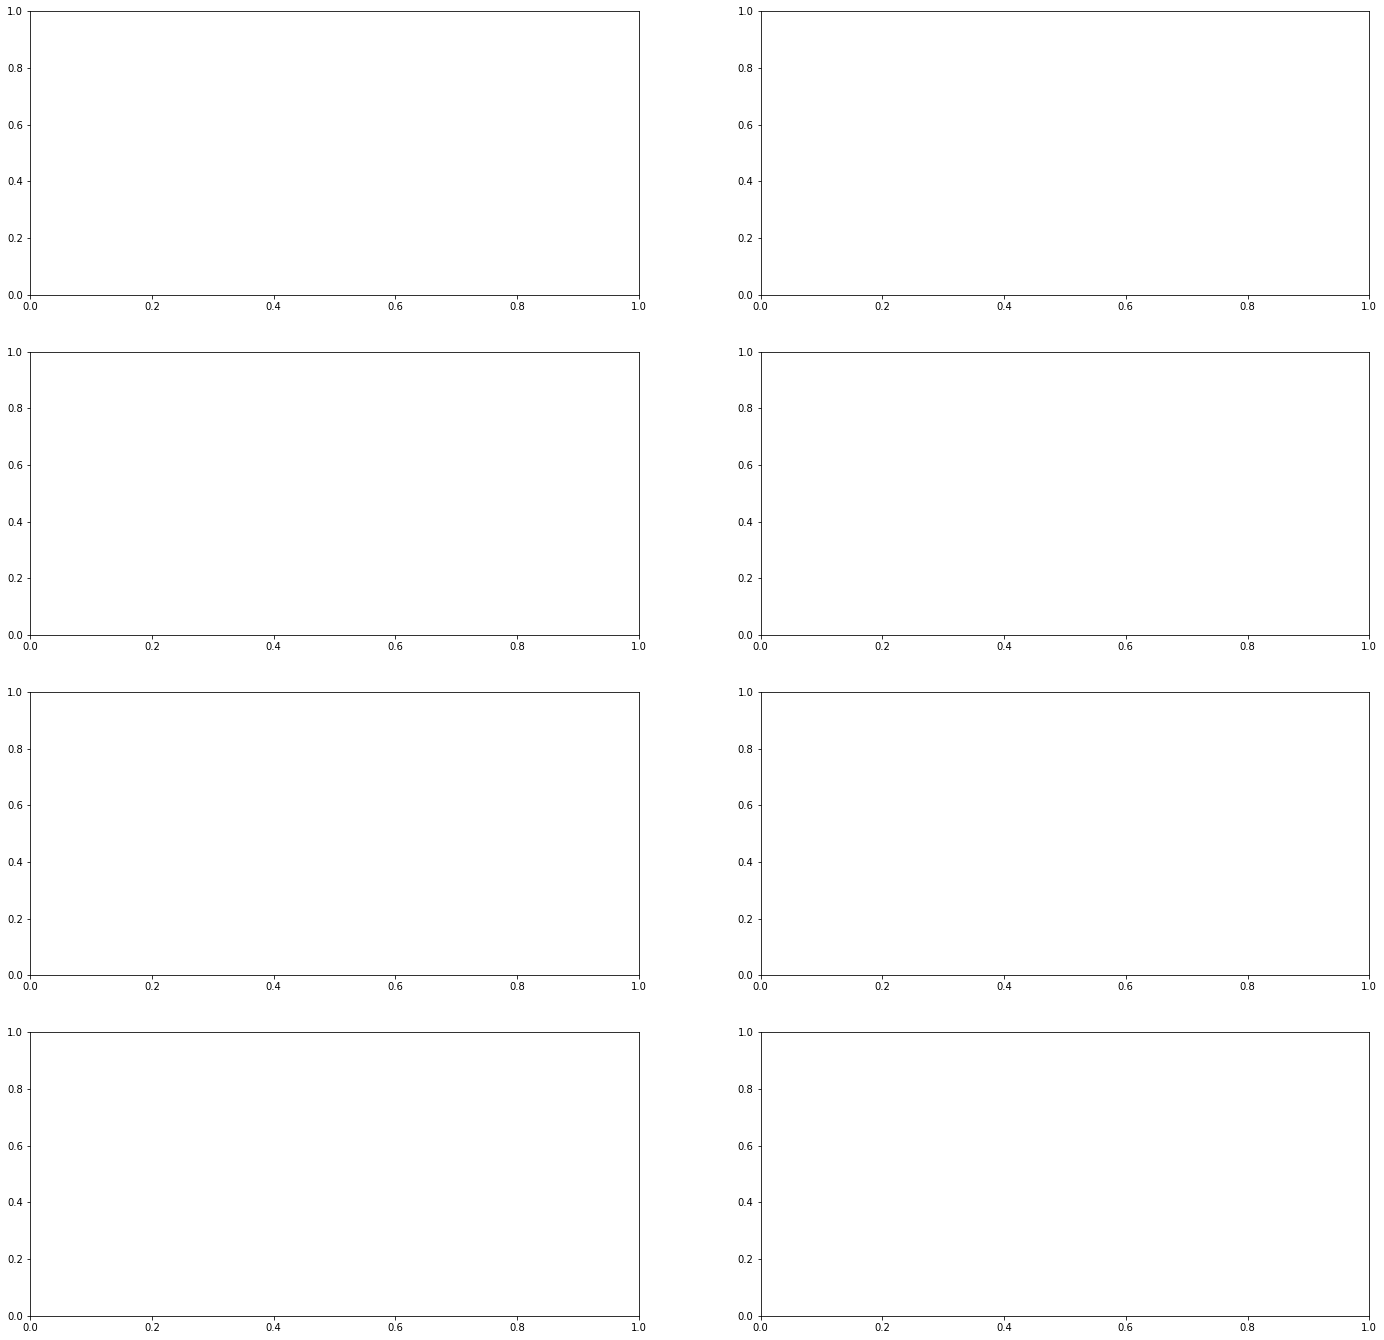

In [54]:
fig, axs = plt.subplots(4, 2, figsize=(24, 24))

type_list = ['w', 'x', 'y', 'z']
for i in range(4):
    A = N_aa_list[i].copy()
    plot1 = axs[i, 0].imshow(np.abs(A), vmin=None, vmax=1)
    axs[i, 0].set_title("$|N_{aa}|$ type:"+type_list[i])
    
    threshold = 0
    A[np.where(A==threshold)] = A.max()
    plot2 = axs[i, 1].imshow(A, vmin=None, vmax=None)
    axs[i, 1].set_title("$N_{aa}$ , with zeros to max(A)"+type_list[i])

    fig.colorbar(plot1, ax=axs[i, 0])
    fig.colorbar(plot2, ax=axs[i, 1])
    
fig.suptitle('Matrix visualization')

# **See iterations**

In [55]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.grid(), plt.legend(), plt.show()
multi_compare_attitudes(gaia, Solver, my_times)
print('MAGNITUDE:', Solver.get_attitude(0.005, unit=False).magnitude)

***** Iteration: 1 *****
241


IndexError: index 244 is out of bounds for axis 0 with size 244